<a href="https://colab.research.google.com/github/MThwa/crypto-analytics/blob/main/20250325_cluster_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.auth import default
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from pandas_gbq import to_gbq
from sklearn.cluster import KMeans
from google.cloud import storage
import joblib

# get credentials
project_id = 'bigtimestudios'
credentials, project_id = default()
client = bigquery.Client(credentials=credentials,project=project_id)

In [ ]:

baseline_query = '''

WITH craftingData AS (
  SELECT
    user_id,
    to_hex(sha256(user_Id)) ga_id,
    COUNT(DISTINCT case when name like "%Recharge%" then a.id end) AS recharges,
    COUNT(DISTINCT case when name like "%Refine%" then a.id end) AS refine,
    COUNT(DISTINCT case when name not like "%Refine%" and name not like "%Recharge%" then a.id end) AS crafts,
  FROM openloot-362008.postgres_rds_crafts_public.crafts a
  LEFT JOIN openloot-362008.postgres_rds_crafts_public.recipes b
    ON a.recipe_id = b.id
  WHERE a.status = 'completed'
  and a.created_at < timestamp('2025-03-27 18:30:22.988721 UTC') and a.created_at > timestamp("2025-02-25 22:57:49.252800 UTC")
  and name not like "%Extract%"
  GROUP BY 1,2
),

tokens as (
  select
  user_id,
  to_hex(sha256(user_Id)) ga_id,
  sum(case when action='grant' and json_extract_scalar(extra,"$.sourceString") like '%epochchest.bigtime%' then amount else 0 end) epochchest_grant,
  sum(case when action='grant' and json_extract_scalar(extra,"$.sourceString") like '%racial%' then amount else 0 end) racial_grant,
  sum(case when action='grant' and json_extract_scalar(extra,"$.sourceString") like '%heldbigtimereward%' then amount else 0 end) heldbigtimereward_grant,
  sum(case when action='grant' and json_extract_scalar(extra,"$.sourceString")='TiTools' then amount else 0 end) airdrop_grant,
  sum(case when action='grant' and source='craft' then amount else 0 end) dismantle_grant,
  from `openloot-362008.postgres_rds_public.token_transactions`
  where token_id='a07b874f-d30a-41d5-bfb1-879abf474590'
  and status = 'completed'
  and action in ('grant')
  and created_at < timestamp('2025-03-27 18:30:22.988721 UTC') and created_at > timestamp("2025-02-25 22:57:49.252800 UTC")
  group by 1,2
  ),

  dungeons as (
  SELECT distinct
  user_id ga_id,
  count(distinct(if(portalType='PvEvP', DungeonInstanceGUID,null))) pvpDungeons,
  count(distinct(if(portalType='PrestigePortal', DungeonInstanceGUID,null))) PrestigeDungeons,
  count(distinct(if(portalType='Portal', DungeonInstanceGUID,null))) PortalDungeons,
  count(distinct(if(portalType='PPU', DungeonInstanceGUID,null))) ppuDungeons,
  FROM `bigtimestudios.PlayerAnalytics.total_dungeons_data`
  unpivot(user_id for user_role in (GCO_PartyMember_0_OpenLootIDSHA256,GCO_PartyMember_1_OpenLootIDSHA256,GCO_PartyMember_2_OpenLootIDSHA256,GCO_PartyMember_3_OpenLootIDSHA256,GCO_PartyMember_4_OpenLootIDSHA256,GCO_PartyMember_5_OpenLootIDSHA256))
  where event_date < date('2025-03-27 18:30:22.988721 UTC')
  and event_date > date("2025-02-25 22:57:49.252800 UTC")
  and portaltype in ('PvEvP','PrestigePortal','Portal','PPU')
  AND (mission IS NULL OR mission NOT LIKE "%FTUE%")
  group by 1

  ),

  users as (
    select
    distinct user_id ga_id
    from bigtimestudios.game_analytics.session_checkpoint_ts
    where checkpoint < date('2025-03-27 18:30:22.988721 UTC')
    and checkpoint > date("2025-02-25 22:57:49.252800 UTC")

  ),

  dataset as (
    select
    d.id user_id,
    d.username,
    coalesce(users.ga_id,a.ga_id,b.ga_id,c.ga_id) ga_id,
    ifnull(recharges,0) recharges,
    ifnull(refine,0) refine,
    ifnull(crafts,0) crafts,
    ifnull(epochchest_grant,0) epochchest_grant,
    ifnull(racial_grant,0) racial_grant,
    ifnull(heldbigtimereward_grant,0) heldbigtimereward_grant,
    ifnull(airdrop_grant,0) airdrop_grant,
    ifnull(dismantle_grant,0) dismantle_grant,
    ifnull(pvpDungeons,0) pvpDungeons,
    ifnull(PrestigeDungeons,0) PrestigeDungeons,
    ifnull(PortalDungeons,0) PortalDungeons,
    ifnull(ppuDungeons,0) ppuDungeons
    from users
    full outer join craftingData a on users.ga_id=a.ga_id
    full outer join tokens b on coalesce(users.ga_id,a.ga_id)=b.ga_id
    full outer join dungeons c on coalesce(users.ga_id,a.ga_id,b.ga_id)=c.ga_id
    left join openloot-362008.postgres_rds_auth_api_public.users d on coalesce(users.ga_id,a.ga_id,b.ga_id,c.ga_id)=to_hex(sha256(d.id))

  )
  select
  *
  from dataset
  where user_id is not null
'''

In [ ]:
# # SQL to access baselinedata
# df = client.query(
#     '''
#     select
#     *
#     from bigtimestudios.BT_ML.march_25_cluster_baseline
#     '''
# ).to_dataframe()

df = client.query(baseline_query).to_dataframe()

In [ ]:
# id non-economy players
df['total'] = df.drop(columns=['user_id','username','ga_id']).sum(axis=1)

# set label for F2P and split out Economy Participants
df_free = df[df['total'] == 0].drop(columns=['total'])
df_free['cluster'] = -1
df_paid = df[df['total'] > 0].drop(columns=['total'])

In [ ]:
# # standardize data
scaler = StandardScaler()
df_paid_scaled = scaler.fit_transform(df_paid.drop(columns=['user_id','username','ga_id']))


Optimal number of components: 9


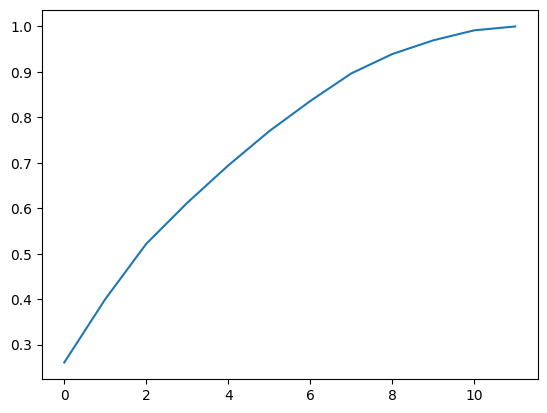

In [ ]:
### Test proper number of components
pca = PCA()
pca.fit_transform(df_paid_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)

# get optimal number of components
optimal_components = np.argmax(explained_variance >= 0.90) + 1
print(f'Optimal number of components: {optimal_components}')

# fit data with components
pca = PCA(n_components=5) # reduced from optimal number to help with KMeans
df_pca = pca.fit_transform(df_paid_scaled)

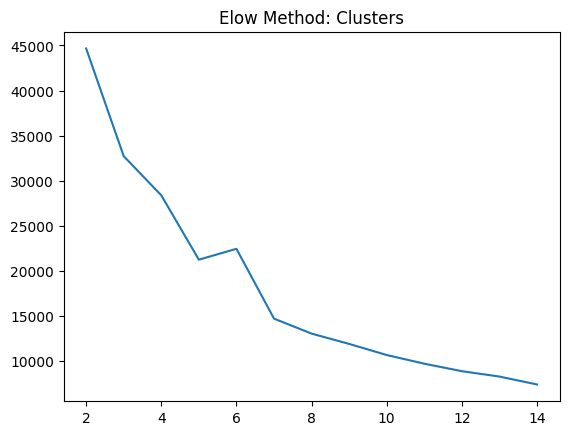

In [ ]:
## Elbow method to find ideal cluster number
wcss = []
for k in range(2,15):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_pca)
  wcss.append(kmeans.inertia_)

plt.plot(range(2,15), wcss)
plt.title('Elow Method: Clusters');

Ideal number of Clusters: 2


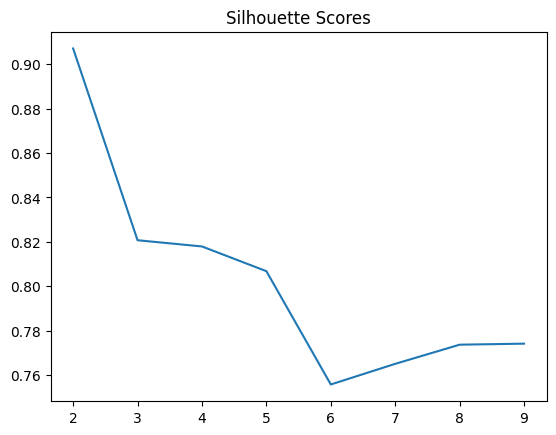

In [ ]:
## silhouette score
silhouette_scores = []
for k in range(2,10):
  kmeans = KMeans(n_clusters=k, random_state=42)
  labels = kmeans.fit_predict(df_pca)
  silhouette = silhouette_score(df_pca, labels)
  silhouette_scores.append(silhouette)

ideal_clusters = np.argmax(silhouette_scores) + 2

print(f'Ideal number of Clusters: {ideal_clusters}')
plt.plot(range(2,10), silhouette_scores)
plt.title('Silhouette Scores')
plt.show();

In [ ]:
# Apply PCA with 6 components
pca = PCA(n_components=6, random_state=42)
df_pca = pca.fit_transform(df_paid_scaled)

#Apply K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_clusters = kmeans.fit_predict(df_pca)

# Add cluster labels back to the DataFrame
df_paid['cluster'] = df_clusters

In [ ]:
df_paid.groupby('cluster').mean(['recharges', 'refine', 'crafts',
       'gamedrop_grants', 'dismantle_grants', 'pvpDungeons',
       'PrestigeDungeons', 'PortalDungeons', 'ppuDungeons'])

,recharges,refine,crafts,epochchest_grant,racial_grant,heldbigtimereward_grant,airdrop_grant,dismantle_grant,pvpDungeons,PrestigeDungeons,PortalDungeons,ppuDungeons
cluster,,,,,,,,,,,,
0,0.885432,2.032112,2.503596,560.624519,3825.519725,40.802224,62.115069,1594.510621,0.075598,13.222278,17.981101,21.9239
1,24.073913,26.4,31.426087,273007.017391,139819.863814,7369.470392,1187.056522,1912.504348,0.473913,421.26087,84.282609,57.995652
2,8.984456,130.0,209.632124,4038.523316,24920.335038,1363.672536,1087.730570,7967.160622,5.388601,127.409326,68.145078,245.373057


In [ ]:
BUCKET_NAME = 'clustering_models'

# Save PCA and KMeans Locally
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(kmeans, 'kmeans.pkl')


# Upload to GCS
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

for model_file in ['scaler.pkl','pca.pkl','kmeans.pkl']:
  blob = bucket.blob(f'20250328_models/{model_file}')
  blob.upload_from_filename(model_file)
  print(f"Uploaded {model_file} to GCS: gs://{BUCKET_NAME}/models/{model_file}")

Uploaded scaler.pkl to GCS: gs://clustering_models/models/scaler.pkl
Uploaded pca.pkl to GCS: gs://clustering_models/models/pca.pkl
Uploaded kmeans.pkl to GCS: gs://clustering_models/models/kmeans.pkl
